### Description (ENG)

The more active our users are, the higher the load on the servers. And lately we have been receiving more and more complaints that the application freezes. Sounds like a challenge for devops and engineers!

You were also asked to contribute to the task - to predict how user activity will change over the next month. Let's try to do this!

**Task:**

1) Select the main metric you plan to forecast. Justify why she is. What temporary permit will you take? Will there be any additional regressors that you will include in the model?

2) Build a model and validate it. Do we have enough data for backtesting with the current task? If not, then determine for what forecasting horizon we have enough data.

3) Choose the model that seems most successful to you (justify your choice). Interpret its results. If there are any important restrictions on the output, do not forget to indicate them too.

### Description (RUS)

Чем активнее наши пользователи – тем выше нагрузка на сервера. И в последнее время нам всё чаще приходят жалобы, что приложение подвисает. Звучит как задача для девопсов и инженеров!

От вас тоже попросили внести свой вклад в задачу – спрогнозировать, как изменится активность пользователей в течение ближайшего месяца. Давайте попробуем это сделать!

**Задание:**

1) Выберите основную метрику, которую вы планируете прогнозировать. Обоснуйте, почему именно она. Какое временное разрешение вы возьмёте? Будут ли какие-то дополнительные регрессоры, которые вы включите в модель?

2) Постройте модель и провалидируйте её. Хватает ли у нас данных для бэктестинга с текущей задачей? Если нет, то определите, для какого горизонта прогнозирования у нас хватает данных.

3) Выберите ту модель, которая кажется вам наиболее удачной (обоснуйте выбор). Проинтерпретируйте её результаты. Если есть какие-то важные ограничения по выводу – не забудьте их тоже указать.

### Metric selection

- Let's take **the total number of user actions** (HAU) as the main metric - it is logical to assume that if the application freezes, then users will have problems performing this or that action - liking or even viewing a post. Moreover, if some users cannot access the application at all due to problems with the server, this will also be reflected in the number of likes and views. As a temporary resolution, we’ll take one **hour** (but here, you probably need to know how much the application freezes: if it’s some minor freezes when loading a page, then you can try to take the resolution for one second).
- In the previous assighnment, we found that holding a flash mob from 2023-10-12 to 2023-10-18 led to a surge in activity on the specified dates. To take this into account, we introduce a dummy variable, which we will include in the model as a regressor. We will not introduce additional regressors, since we do not know anything reliably about their future values ​​- we can either predict them in the same way, or generate them in some range, which does not make sense in this task.

In [1]:
import numpy as np
import pandas as pd
import pandahouse

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
import orbit #general module
from orbit.models import DLT, KTR 
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components #to draw a forecast
from orbit.diagnostics.backtest import BackTester #main class for backtesting
from orbit.utils.params_tuning import grid_search_orbit #to find optimal parameters

First, let's extract data from ClickHouse.

In [55]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}

q = """
select toStartOfHour(time) as date_hour, count(action) as num_actions
from simulator_20231020.feed_actions
group by date_hour
order by date_hour
"""
activity = pandahouse.read_clickhouse(q, connection=connection)

In [56]:
activity.head()

,date_hour,num_actions
0,2023-09-01 00:00:00,22
1,2023-09-01 01:00:00,32
2,2023-09-01 02:00:00,24
3,2023-09-01 03:00:00,11
4,2023-09-01 04:00:00,18


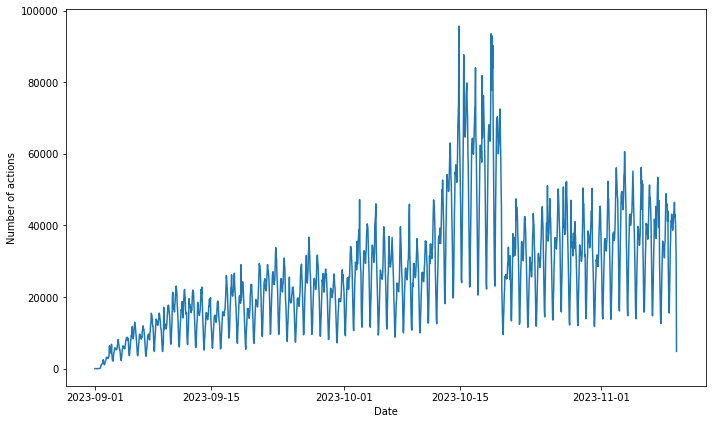

In [57]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(activity.date_hour, activity.num_actions)
ax.set(xlabel='Date', ylabel='Number of actions')

fig.tight_layout()

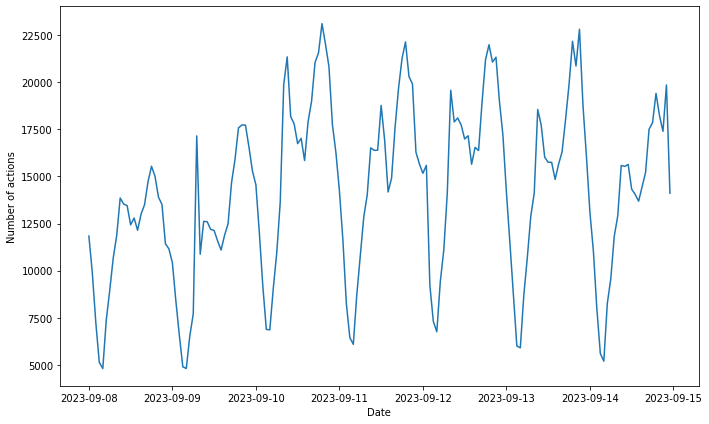

In [58]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(activity.date_hour[24*7:24*7*2], activity.num_actions[24*7:24*7*2])
ax.set(xlabel='Date', ylabel='Number of actions')

fig.tight_layout()

The figure clearly shows daily seasonality.

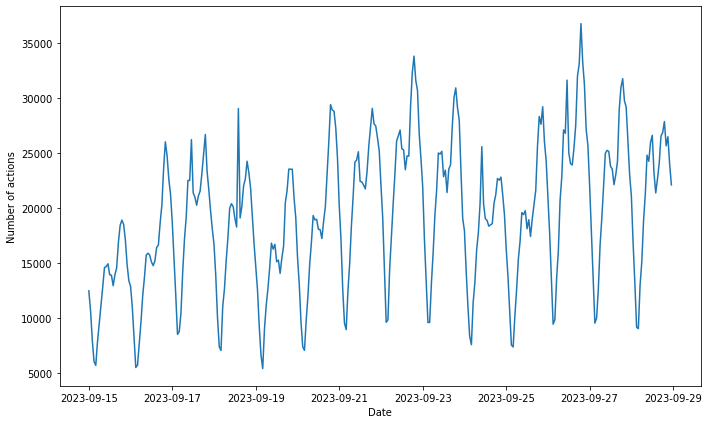

In [59]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(activity.date_hour[24*7*2:24*7*4], activity.num_actions[24*7*2:24*7*4])
ax.set(xlabel='Date', ylabel='Number of actions')

fig.tight_layout()

And also there is a weekly seasonality.

Let's introduce a flashmob dummy variable:

In [60]:
# Введем дамми-переменную флэшмоба

activity['flashmob'] = activity.date_hour.transform(lambda x: 
                                        1 if pd.Timestamp(2023, 10, 12) <= x < pd.Timestamp(2023, 10, 19) else 0)

In [61]:
activity.shape

(1682, 3)

In [62]:
activity['date'] = activity.date_hour.dt.date
activity.head()

,date_hour,num_actions,flashmob,date
0,2023-09-01 00:00:00,22,0,2023-09-01
1,2023-09-01 01:00:00,32,0,2023-09-01
2,2023-09-01 02:00:00,24,0,2023-09-01
3,2023-09-01 03:00:00,11,0,2023-09-01
4,2023-09-01 04:00:00,18,0,2023-09-01


In [63]:
activity.date.nunique()

71

### Do we have enough data for backtesting?

We have only 71 days available for backtesting. Considering that we want to make a forecast for a month (30 days), we can safely say that there is not enough data - the quality of such a forecast will be obviously low. The optimal ratio of data dimensions for backtesting / forecast should be $\approx$ 80 / 20. Now it is $\approx$ 58 / 42. Therefore, let’s consider a planning horizon of **2 weeks** instead of a month.

In [64]:
activity.tail(3)

,date_hour,num_actions,flashmob,date
1679,2023-11-09 23:00:00,36794,0,2023-11-09
1680,2023-11-10 00:00:00,29971,0,2023-11-10
1681,2023-11-10 01:00:00,4833,0,2023-11-10


In [65]:
activity.drop(1681, axis=0, inplace=True)

### DLT model with regressor (MAP estimator)

First, let's build a DLT model with an introduced binary variable as a regressor and a MAP estimation algorithm.

In [66]:
dlt = DLT(response_col="num_actions", #название колонки с метрикой
          date_col="date_hour", #название колонки с датами-временем
          seasonality=24, #длина периода сезонности = сутки
          estimator="stan-map", #алгоритм оценки
          n_bootstrap_draws=1000, #количество сэмплов бутстрапа для доверительного интервала
          regressor_col=["flashmob"],
          #regression_penalty="auto_ridge",
          regressor_sign="+"
          ) 

2023-11-09 22:11:21 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.


In [67]:
activity = activity.astype({'num_actions':'int64'})

Let's train the model:

In [68]:
# Обучаем модель

dlt.fit(activity) 

And create a dataframe for which we will make a forecast (we decided that it will be 2 weeks): 

In [69]:
# Создаем датафрейм, для которого будем делать прогноз 

future_df = dlt.make_future_df(periods=24*14) 

# горизонт будет 14 дней (чтобы прогноз был точнее)

We assume that there won't be any other flashmobs in the following 2 weeks:

In [70]:
# Предполагаем, что новых флешмобов в следующем месяце не запланировано

future_df['flashmob'] = 0

In [71]:
future_df

,date_hour,flashmob
0,2023-11-10 01:00:00,0
1,2023-11-10 02:00:00,0
2,2023-11-10 03:00:00,0
3,2023-11-10 04:00:00,0
4,2023-11-10 05:00:00,0
...,...,...
331,2023-11-23 20:00:00,0
332,2023-11-23 21:00:00,0
333,2023-11-23 22:00:00,0
334,2023-11-23 23:00:00,0


Now, we can make a forecast.

In [72]:
# Прогнозируем 

predicted_df = dlt.predict(df=future_df)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

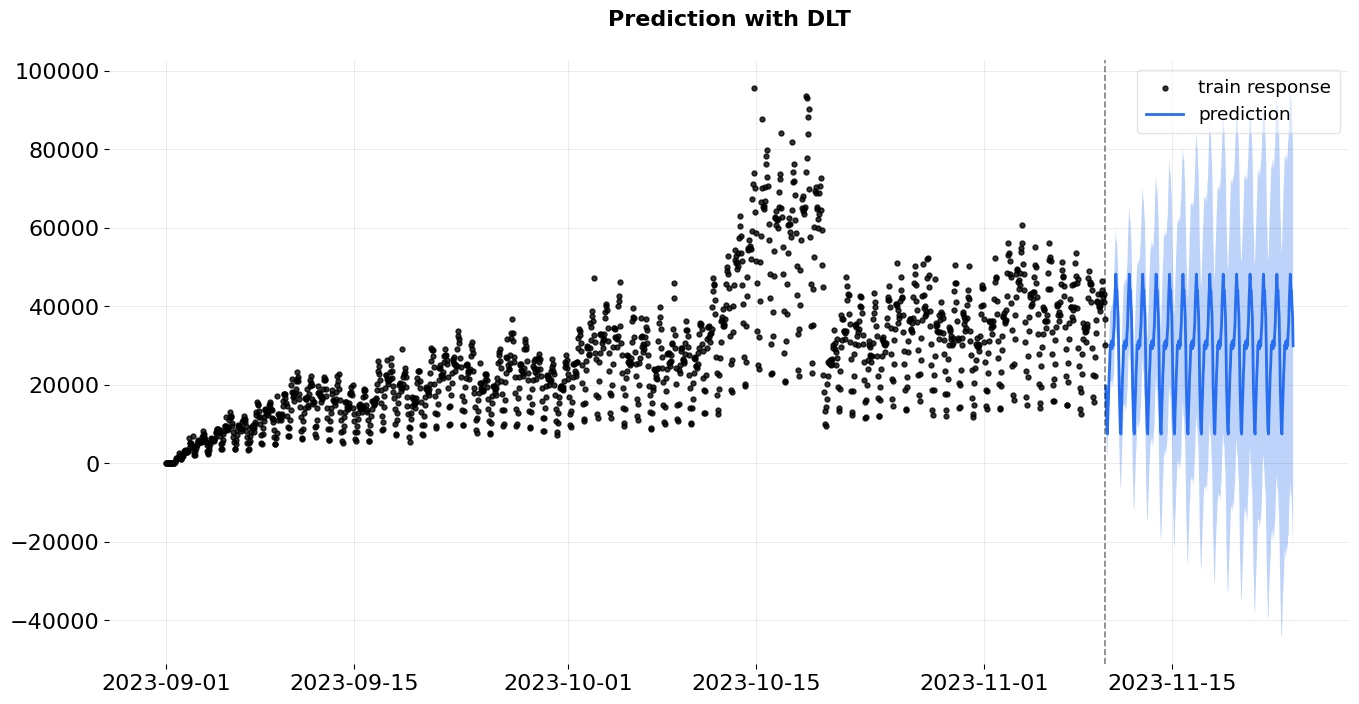

In [73]:
_ = plot_predicted_data(activity, #изначальные данные
                        predicted_df, #датафрейм с предсказаниями
                        'date_hour', #колонка со временем
                        'num_actions', #колонка со значениями временного ряда
                        title='Prediction with DLT') #заголовок рисунка

**The metric forecast looks adequate - at least activity is not falling. Let's validate the model.**

In [76]:
from orbit.diagnostics.backtest import BackTester #основной класс для бэктестинга

bt_exp = BackTester(
    model=dlt, #наша моделька
    df=activity, #датафрейм для обучения
    min_train_len=24*7, #самый маленький кусочек данных, с которого начинается обучение
    incremental_len=24*7, #на сколько происходит прирост тренировочных данных
    forecast_len=24*7, #горизонт прогнозирования
    window_type="expanding" #тип окошка
)

In [77]:
bt_exp.fit_predict() #обучаем
bt_exp.score() #выводим метрики

,metric_name,metric_values,is_training_metric
0,smape,2.367630e-01,False
1,wmape,2.506726e-01,False
2,mape,2.629983e-01,False
3,mse,1.100730e+08,False
4,mae,7.232941e+03,False
5,rmsse,2.415237e+00,False


**Conclusion:** judging by the values of the error metrics (e.g. RMSSE), the accuracy of our model leaves much to be desired. Let's try to consider another model.

### KTR model with regressor

Let's build a kernal model with time-varying regression. Firstly, such a model will allow us to take into account not only the daily, but also the weekly seasonality that we observe. Secondly, KTR works more flexibly with regressors and has lower computational costs.

In [97]:
ktr = KTR(response_col="ln_num_actions", #название колонки с метрикой (логарифмированной)
          date_col="date_hour", #название колонки с датами-временем
          seasonality=[24,24*7], #длина периодов сезонности = суто и недели
          estimator="pyro-svi", #алгоритм оценки
          n_bootstrap_draws=1000, #количество сэмплов бутстрапа для доверительного интервала
          regressor_col=["flashmob"],
          regressor_sign="+"
          ) 

Let’s also take a logarithm of the data:

In [98]:
activity['ln_num_actions'] = np.log(activity.num_actions)

In [99]:
ktr.fit(activity)

2023-11-09 22:45:42 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.
2023-11-09 22:45:42 - orbit - INFO - Using SVI (Pyro) with steps: 301, samples: 100, learning rate: 0.1, learning_rate_total_decay: 1.0 and particles: 100.
INFO:orbit:Using SVI (Pyro) with steps: 301, samples: 100, learning rate: 0.1, learning_rate_total_decay: 1.0 and particles: 100.
2023-11-09 22:45:42 - orbit - INFO - step    0 loss = 1435.9, scale = 0.0923
INFO:orbit:step    0 loss = 1435.9, scale = 0.0923
2023-11-09 22:45:55 - orbit - INFO - step  100 loss = 140.72, scale = 0.10565
INFO:orbit:step  100 loss = 140.72, scale = 0.10565
2023-11-09 22:46:08 - orbit - INFO - step  200 loss = 140.83, scale = 0.11533
INFO:orbit:step  200 loss = 140.83, scale = 0.11533
2023-11-09 22:46:21 - orbit - INFO - step  300 loss = 140.27, scale = 0.1149
INFO:orbit:step  300 loss = 140.27, scale = 0.1149


**Now, we make a forecast:**

In [129]:
# Прогнозируем 

predicted_df = ktr.predict(df=future_df)

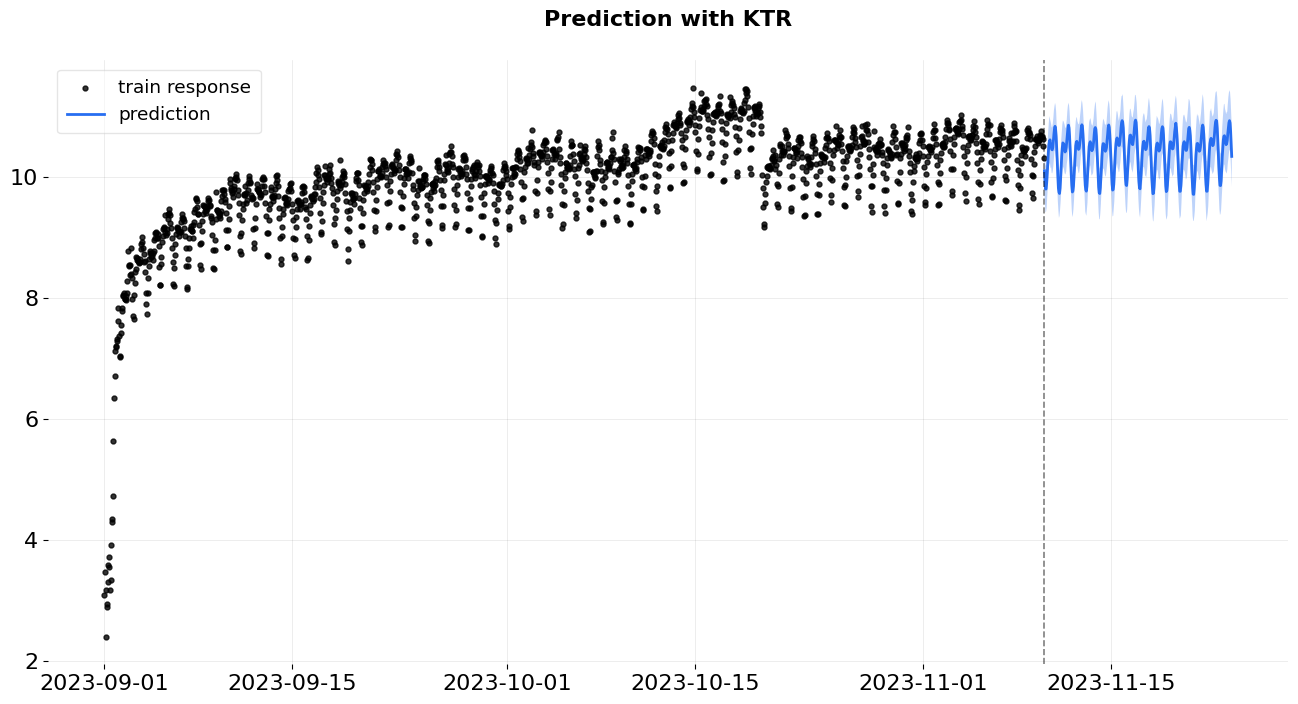

In [130]:
_ = plot_predicted_data(activity, #изначальные данные
                        predicted_df, #датафрейм с предсказаниями
                        'date_hour', #колонка со временем
                        'ln_num_actions', #колонка со значениями временного ряда
                        title='Prediction with KTR') #заголовок рисунка

**Let's validate the model:**

In [131]:
bt_exp = BackTester(
    model=ktr, #наша моделька
    df=activity, #датафрейм для обучения
    min_train_len=24*7, #самый маленький кусочек данных, с которого начинается обучение
    incremental_len=24*7, #на сколько происходит прирост тренировочных данных
    forecast_len=24*7, #горизонт прогнозирования
    window_type="expanding" #тип окошка
)

In [132]:
bt_exp.fit_predict() #обучаем
bt_exp.score() #выводим метрики

2023-11-09 23:33:14 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.
2023-11-09 23:33:14 - orbit - INFO - Using SVI (Pyro) with steps: 301, samples: 100, learning rate: 0.1, learning_rate_total_decay: 1.0 and particles: 100.
INFO:orbit:Using SVI (Pyro) with steps: 301, samples: 100, learning rate: 0.1, learning_rate_total_decay: 1.0 and particles: 100.
2023-11-09 23:33:14 - orbit - INFO - step    0 loss = 88.661, scale = 0.09599
INFO:orbit:step    0 loss = 88.661, scale = 0.09599
2023-11-09 23:33:21 - orbit - INFO - step  100 loss = -62.781, scale = 0.1705
INFO:orbit:step  100 loss = -62.781, scale = 0.1705
2023-11-09 23:33:28 - orbit - INFO - step  200 loss = -62.865, scale = 0.1741
INFO:orbit:step  200 loss = -62.865, scale = 0.1741
2023-11-09 23:33:35 - orbit - INFO - step  300 loss = -62.048, scale = 0.17273
INFO:orbit:step  300 loss = -62.048, scale = 0.17273
2023-11-09 23:33:36 - orbit - INFO - Optimizing (PyStan) w

,metric_name,metric_values,is_training_metric
0,smape,0.034361,False
1,wmape,0.033621,False
2,mape,0.033869,False
3,mse,0.198890,False
4,mae,0.340716,False
5,rmsse,2.695355,False


**It has become much better compared to the DLT model. Let's move from logarithmic data to the usual ones.**

In [133]:
predicted_df.head(3)

,date_hour,prediction_5,prediction,prediction_95
0,2023-11-10 01:00:00,9.709559,10.096475,10.472458
1,2023-11-10 02:00:00,9.559911,9.921818,10.274901
2,2023-11-10 03:00:00,9.409982,9.795208,10.180410


In [134]:
predicted_df['prediction_5'] = np.exp(predicted_df.prediction_5)
predicted_df['prediction_95'] = np.exp(predicted_df.prediction_95)
predicted_df['prediction'] = np.exp(predicted_df.prediction)

Let's visualize the result:

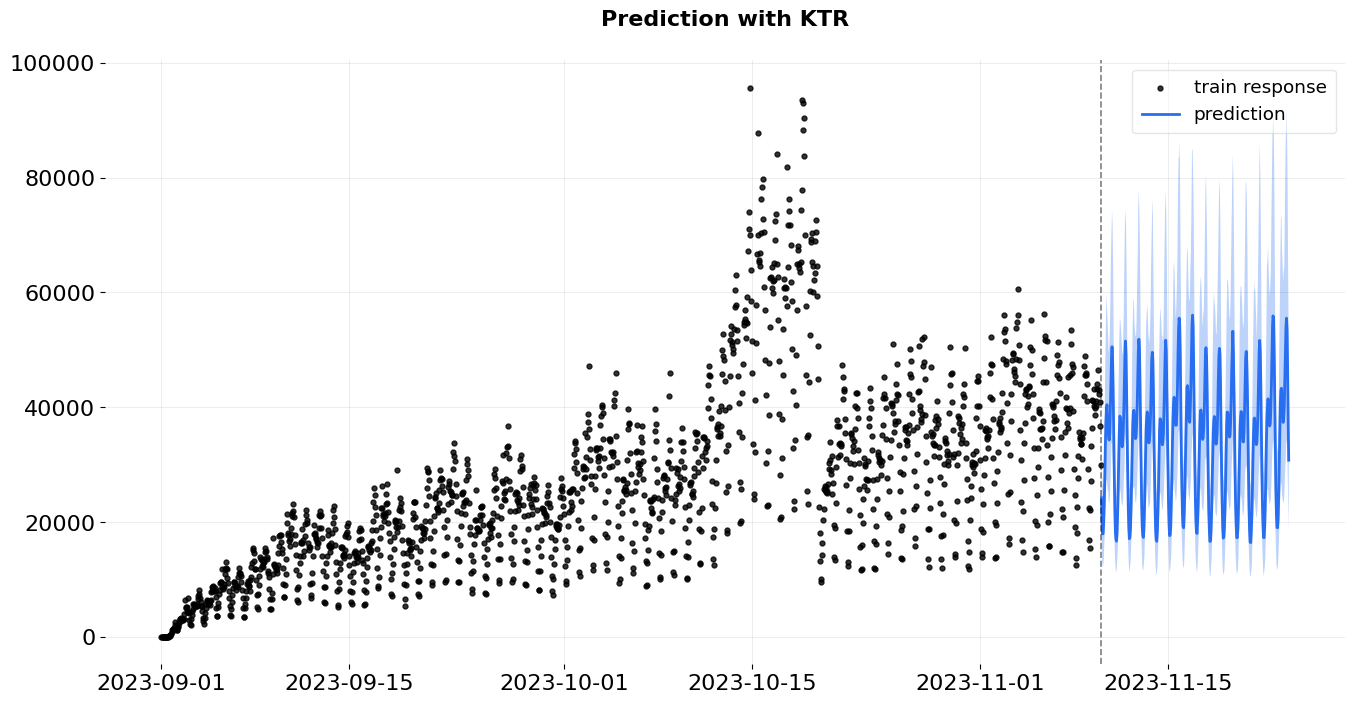

In [135]:
_ = plot_predicted_data(activity, #изначальные данные
                        predicted_df, #датафрейм с предсказаниями
                        'date_hour', #колонка со временем
                        'num_actions', #колонка со значениями временного ряда
                        title='Prediction with KTR') #заголовок рисунка

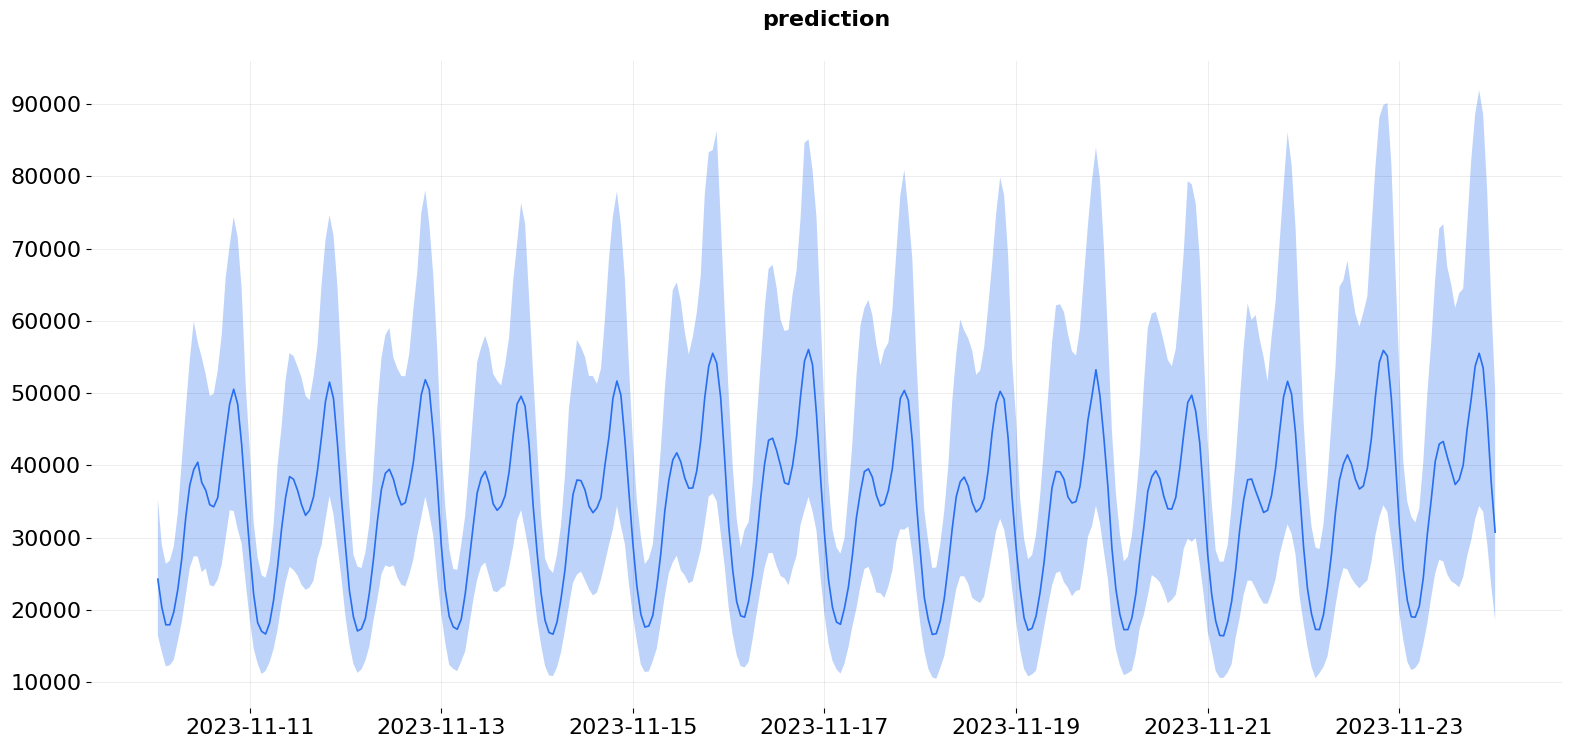

array([<Axes: title={'center': 'prediction'}>], dtype=object)

In [136]:
plot_predicted_components(predicted_df=predicted_df, 
                          date_col='date_hour', plot_components=['prediction'])

### Results

**Conclusion**, given that there are only 71 days of data for backtesting, it was decided to make a forecast for 2 weeks instead of a month. According to the forecast, in the next 14 days the number of user actions per hour will vary from 16,400 to 57,229 depending on the time of day and day of the week. Taking into account the confidence interval, the predicted values ​​can vary from 10,500 to 93,000 actions (depending on the time of day and day of the week). The forecast was also made on the assumption that repeated flash mobs and other events that could lead to a surge in activity are not expected in the next two weeks.

In [137]:
predicted_df.agg({'prediction':'min', 'prediction_5':'min', 'prediction_95':'min'})

prediction       16427.436707
prediction_5     10469.002648
prediction_95    24458.830761
dtype: float64

In [138]:
predicted_df.agg({'prediction':'max', 'prediction_5':'max', 'prediction_95':'max'})

prediction       56040.794510
prediction_5     36102.144555
prediction_95    91924.613857
dtype: float64